### Load Python Package

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from datetime import date
import seaborn as sns
from shapely.geometry import Point, MultiPolygon
import geojson
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy as sp
from statsmodels.graphics import utils
import statsmodels.stats.api as sms
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.stats.stattools as stools
%matplotlib inline

### Load Training dataet

In [12]:
train = pd.read_csv('./data/transformed_train.csv')
print ("Training data has {} rows and {} columns".format(train.shape[0],train.shape[1]))
print ("data : {}".format(train.shape[0]))
print ("Feature : {}".format(train.shape[1]))

Training data has 701778 rows and 32 columns
data : 701778
Feature : 32


In [13]:
train.shape

(701778, 32)

## feature Selection

####  변수 선정
* 초기 모델을 위한 feature 선정
> EDA 결과
> * Distance / dummy_manhattan_dist / Distance & dummay_manhattan
> * Hour
   * weekend / rest_day / day_of_week 중 하나를 선택하여 interaction 설정
> * pickup_Province
> * dropoff_Province

#### 선택된 독립변수를 제외한 나머지 독립변수가 종속변수에 영향을 주는 정도를 확인

In [14]:
model1 = sm.OLS.from_formula(
    "np.log(trip_duration) ~ scale(passenger_count) + scale(bearing)  +  C(vendor_id) + C(store_and_fwd_flag) + C(Event) + C(pickup_dropoff_same_Province)"
    , data = train)
result1 = model1.fit()
sm.stats.anova_lm(result1, typ=2)

,sum_sq,df,F,PR(>F)
C(vendor_id),75.943643,1.0,151.117391,9.961155e-35
C(store_and_fwd_flag),4.394340,1.0,8.744132,3.106103e-03
C(Event),11.121952,1.0,22.131154,2.546919e-06
C(pickup_dropoff_same_Province),85030.257278,1.0,169198.502313,0.000000e+00
scale(passenger_count),59.663010,1.0,118.721173,1.211529e-27
scale(bearing),1136.920270,1.0,2262.314769,0.000000e+00
Residual,352673.149377,701771.0,NaN,NaN


* 추가 변수 선정
> * pickup_dropoff_same_Province
   * pickup과 dropoff의 위치가 같은지 여부에 대한 판단
> * bearing

####  최종 변수 선정
* Distance or dummy_manhattan_dist or Distance & dummay_manhattan
> * Distance, dummy_manhattan_dist 둘다 사용
* Hour 
> * day_of_week
* pickup_Province
* dropoff_Province
* pickup_dropoff_same_Province
* bearing

#### Linear Regression

In [15]:
formulaIs = 'I(np.log(trip_duration)) ~ I(np.log(distance+0.1)) +I(np.log(dummy_manhattan_dist+0.1)) +scale(bearing)+ C(pickup_Province) +C(dropoff_Province) +C(pickup_dropoff_same_Province)+C(hr):C(day_of_week)'
fList = ['distance','dummy_manhattan_dist','bearing','pickup_Province','dropoff_Province','pickup_dropoff_same_Province','hr','day_of_week']
modelFinal = sm.OLS.from_formula(formulaIs, data=train)
result = modelFinal.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     I(np.log(trip_duration))   R-squared:                       0.645
Model:                                  OLS   Adj. R-squared:                  0.645
Method:                       Least Squares   F-statistic:                     7053.
Date:                      Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                              13:49:45   Log-Likelihood:            -4.6671e+05
No. Observations:                    701778   AIC:                         9.338e+05
Df Residuals:                        701596   BIC:                         9.359e+05
Df Model:                               181                                         
Covariance Type:                  nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 5.5694      0.022    248.635      0.000       5.526       5.613
C(pickup_Province)[T.Brooklyn]           -0.1857      0.021     -9.023      0.000      -0.226      -0.145
C(pickup_Province)[T.Manhattan]          -0.1308      0.020     -6.512      0.000      -0.170      -0.091
C(pickup_Province)[T.Queens]             -0.2670      0.020    -13.165      0.000      -0.307      -0.227
C(pickup_Province)[T.Staten Island]       1.5343      0.094     16.261      0.000       1.349       1.719
C(pickup_Province)[T.outward]            -0.2828      0.029     -9.793      0.000      -0.339      -0.226
C(dropoff_Province)[T.Brooklyn]           0.2221      0.008     28.733      0.000       0.207       0.237
C(dropoff_Province)[T.Manhattan]          0.2013      0.008     26.390      0.000       0.186       0.216
C(dropoff_Province)[T.Queens]             0.0879      0.008     11.363      0.000       0.073       0.103
C(dropoff_Province)[T.Staten Island]      0.1167      0.038      3.093      0.002       0.043       0.191
C(dropoff_Province)[T.outward]           -0.0158      0.012     -1.340      0.180      -0.039       0.007
C(pickup_dropoff_same_Province)[T.1]     -0.0457      0.003    -15.761      0.000      -0.051      -0.040
C(day_of_week)[T.1]                       0.0559      0.015      3.764      0.000       0.027       0.085
C(day_of_week)[T.2]                       0.0857      0.014      5.997      0.000       0.058       0.114
C(day_of_week)[T.3]                       0.0962      0.014      6.993      0.000       0.069       0.123
C(day_of_week)[T.4]                       0.1755      0.013     13.774      0.000       0.151       0.200
C(day_of_week)[T.5]                       0.2757      0.012     22.735      0.000       0.252       0.299
C(day_of_week)[T.6]                       0.2730      0.012     22.419      0.000       0.249       0.297
C(hr)[T.1]:C(day_of_week)[0]             -0.0309      0.017     -1.766      0.077      -0.065       0.003
C(hr)[T.2]:C(day_of_week)[0]             -0.0095      0.021     -0.461      0.645      -0.050       0.031
C(hr)[T.3]:C(day_of_week)[0]              0.0063      0.023      0.274      0.784      -0.039       0.052
C(hr)[T.4]:C(day_of_week)[0]             -0.0814      0.022     -3.710      0.000      -0.124      -0.038
C(hr)[T.5]:C(day_of_week)[0]             -0.0884      0.018     -4.813      0.000      -0.124      -0.052
C(hr)[T.6]:C(day_of_week)[0]              0.0050      0.014      0.353      0.724      -0.023       0.033
C(hr)[T.7]:C(day_of_week)[0]              0.2567      0.013     20.080      0.000       0.232       0.282
C(hr)[T.8]:C(day_of_week)[0]              0.4490 

#### 실제값과 회귀모델 식으로 구한 값사이의 연관성을 확인

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['nanumgothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


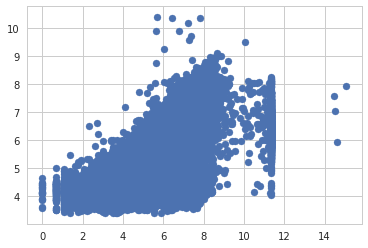

In [16]:
y_new = result.predict(train[fList])
y = train.apply(lambda x:np.log(x.trip_duration),axis=1)
plt.scatter(y,y_new)

#### Cross Validation을 통한 모델 검증

In [17]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)

748471.52754339, 750516.8850630295, -374053.763771695, 0.644629756418138, 0.6445151494512642, 409.40993121510553
0.465229321337
745691.4871435165, 747736.844663156, -372663.74357175827, 0.6455010835280246, 0.6453867575642989, 448.2367342183364
0.469900585471
746155.5152342061, 748200.8727538455, -372895.75761710305, 0.6468820119087652, 0.6467681312946882, 408.4126108618555
0.469330974036
747628.2608815463, 749673.6187253622, -373632.13044077315, 0.6451020667235987, 0.6449876122808138, 405.3909170311225
0.466710036158
747350.4166726456, 749395.7745164615, -373493.2083363228, 0.6446972550685439, 0.6445826700741608, 417.9668254387614
0.46717040592


/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['nanumgothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


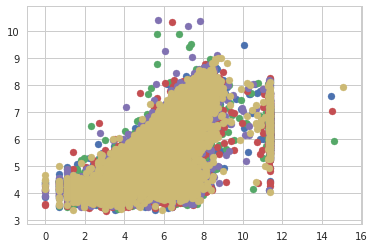

In [22]:
for train_index, test_index in cv.split(train):
    cTrainDe = train.loc[train_index][fList+['trip_duration']]
    modelc = sm.OLS.from_formula(formulaIs,cTrainDe)
    resultc = modelc.fit()
    x = '{}, {}, {}, {}, {}, {}'.format(resultc.aic,resultc.bic,resultc.llf, resultc.rsquared, resultc.rsquared_adj, resultc.condition_number)
    print (x)
    cTest = train.loc[test_index][fList+['trip_duration']]
    yc_new = resultc.predict(cTest[fList])
    yc_newis = np.exp(yc_new)
    rmsleIs = rmsle(cTest['trip_duration'],yc_newis)
    print (rmsleIs)
    yc = train.loc[test_index].apply(lambda x:np.log(x.trip_duration),axis=1)
    plt.scatter(yc,yc_new) 

#### 종속변수에 대한 독립변수의 영향도를 F 검정을 사용하여 비교

In [23]:
sm.stats.anova_lm(result,typ =2)

,sum_sq,df,F,PR(>F)
C(pickup_Province),629.395140,5.0,568.418082,0.000000e+00
C(dropoff_Province),599.521756,5.0,541.438891,0.000000e+00
C(pickup_dropoff_same_Province),55.014521,1.0,248.423023,5.859547e-56
C(hr):C(day_of_week),20575.083109,167.0,556.339161,0.000000e+00
I(np.log(distance + 0.1)),8935.507488,1.0,40349.088385,0.000000e+00
I(np.log(dummy_manhattan_dist + 0.1)),1762.850300,1.0,7960.309212,0.000000e+00
scale(bearing),529.191717,1.0,2389.612833,0.000000e+00
Residual,155371.944264,701596.0,NaN,NaN


#### 잔차의 정규성을 확인

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['nanumgothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


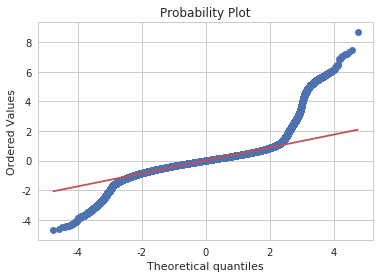

In [24]:
sp.stats.probplot(result.resid, plot=plt)
plt.show()

* 정규성 검정을 통해 확인

In [25]:
test = sms.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print ("%-10s: %6.3f " % xi)

Chi^2     : 361412.732 
P-value   :  0.000 


In [26]:
test = sms.jarque_bera(result.resid)
for xi in zip(['Jarque-Bera', 'P-value', 'Skew', 'Kurtosis'], test):
    print("%-12s: %6.3f" % xi)

Jarque-Bera : 14598236.740
P-value     :  0.000
Skew        :  1.812
Kurtosis    : 25.048


#### 잔차와 독립변수의 관계 확인
* 이분산성

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['nanumgothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


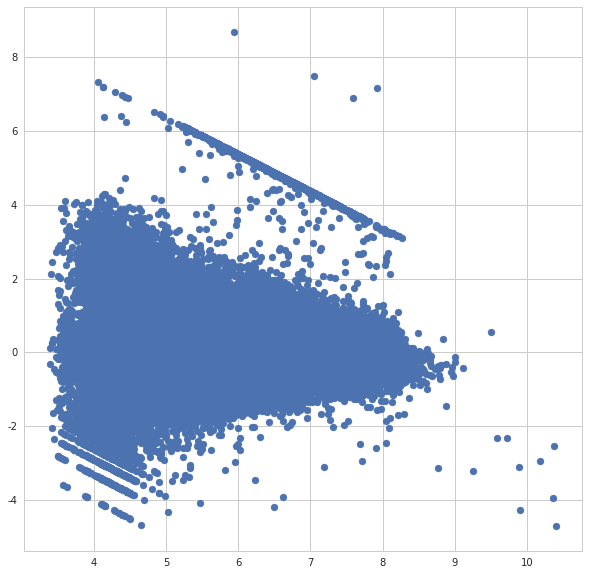

In [27]:
fig = plt.figure(figsize=(10,10))
plt.scatter(result.predict(),result.resid)
plt.show()

* 종속변수를 log-transform을 하였는데 이분산성이 나타나는 것을 확인함.

#### 자기 상관 계수 확인
* 오차가 독립인지를 검정

In [28]:
print (stools.durbin_watson(result.resid))

1.95271874351


#### 모델 결과
* R-square : 0.65
* Adj. R-squared : 0.645
* F-statistic:	7053.
* Prob (F-statistic) : 0.00
* Log-Likelihood : -4.6671e+05
* AIC :	9.338e+05
* BIC :	9.359e+05
* condition Number : 417

##### Root Mean Squared Logarithmic Error (RMSLE)

In [20]:
def rmsle(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))

In [29]:
y_newis = np.exp(y_new)
rmsle(train['trip_duration'],y_newis)

0.46751648285915259

#### Leverage & Outlier

In [ ]:
inf = result.get_influence()
hat = inf.hat_matrix_diag
print('hat.sum() =',hat.sum())
x_new = train[fList]
y_new = result.predict()

hat.sum() = 182.0


* Fox recommentation 기준 Outlier 선정

In [ ]:
cooks_d2, pvals = inf.cooks_distance
fox_cr = 4 / (len(train['trip_duration']) - 182)
idx = np.where(cooks_d2 > fox_cr)[0]
ax = plt.subplot()
plt.scatter(y_new,train['trip_duration'])
plt.scatter(y_new[idx], train['trip_duration'][idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx, 
                    list(zip(y_new[idx], train['trip_duration'][idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
plt.show()
len(idx)

* Fox Recommendation을 통해 21868개의 데이터가 outlier로 선정되었고, 이를 제거하고 추가 분석을 실시

In [ ]:
filter_X =train[:]
filter_X.drop(idx,0,inplace = True)

filter_X.tail()
print (train.shape)
print (filter_X.shape)

In [ ]:
modela = sm.OLS.from_formula(formulaIs,data = filter_X)
resulta = modela.fit()
resulta.summary()

#### 실제값과 회귀모델 식으로 구한 값사이의 연관성을 확인

In [ ]:
y_newa = resulta.predict(filter_X[fList])
ya = filter_X.apply(lambda x:np.log(x.trip_duration),axis=1)
#ya = filter_X['trip_duration']
plt.scatter(ya,y_newa)

#### 종속변수에 대한 독립변수의 영향도를 F 검정을 사용하여 비교

In [ ]:
sm.stats.anova_lm(resulta,typ =2)

#### 잔차의 정규성을 확인

In [ ]:
sp.stats.probplot(resulta.resid, plot=plt)
plt.show()

In [ ]:
test = sms.omni_normtest(resulta.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print ("%-10s: %6.3f " % xi)

In [ ]:
test = sms.jarque_bera(resulta.resid)
for xi in zip(['Jarque-Bera', 'P-value', 'Skew', 'Kurtosis'], test):
    print("%-12s: %6.3f" % xi)

* 잔차의 정규성을 확인했을때, outlier를 제거하기 전보다 좋아지는 것을 확인하였으나 정규분포를 따르지 않는다는 것을 확인

#### 잔차와 독립변수의 관계 확인
* 이분산성

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.scatter(resulta.predict(),resulta.resid)
plt.show()

* 자기 상관 계수 확인

In [ ]:
print (stools.durbin_watson(resulta.resid))

##### Root Mean Squared Logarithmic Error (RMSLE)

In [ ]:
y_newais = np.exp(y_newa)
rmsle(filter_X['trip_duration'],y_newais)

#### Test 결과 도출

In [ ]:
test = pd.read_csv('./data/transformed_test.csv')
print ("Training data has {} rows and {} columns".format(test.shape[0],test.shape[1]))
print ("data : {}".format(test.shape[0]))
print ("Feature : {}".format(test.shape[1]))

In [ ]:
print (test.shape)
test.describe()

In [ ]:
testy = resulta.predict(test[fList])

In [ ]:
tx = pd.concat([test['id'],testy],axis=1)

In [ ]:
tx.rename({0:"trip_duration"},inplace = True)

In [ ]:
tx.to_csv('./data/submission_Sigma.csv',index = False)

In [ ]:
answer = pd.read_csv('./data/test_answer_nyc_taxi.csv',low_memory=False)
answer.dropna(axis=0,inplace = True)

In [ ]:
rmsle(answer.trip_duration, np.exp(testy))

#### 결과
* Feature에 대한 이해를 통하여 회귀 모델을 만드는 것이 중요하다는 생각으로 접근
* Linear Regresssion 모델을 통하여 예측을 해보고자 하였음
 * 최종으로 도출된 모델에서 잔차의 정규성이 맞는 않는 것을 확인
 * 개선의 필요성이 있음
* pickup 위치와 dropoff위치를 뉴욕의 주단위로 묶어서 진행하였는데 좀 더 세분화하여 진행하면 더 정확해지지 않을까라는 생각을 함
* 클러스터링이나 다른 분석기법을 이용하여 좀 더 정확한 예측이 가능할 것으로 판단됨
* outlier를 어떻게 처리하는지에 대하여 좀더 생각해볼 필요성을 느낌
